In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
### Load the .npz data and convert to tensors ###

npz_data = np.load('data/audiobooks_data_split.npz')

X_train = tf.convert_to_tensor(npz_data['X_train'], dtype=tf.float64)
X_val = tf.convert_to_tensor(npz_data['X_val'], dtype=tf.float64)
X_test = tf.convert_to_tensor(npz_data['X_test'], dtype=tf.float64)
y_train = tf.convert_to_tensor(npz_data['y_train'], dtype=tf.int8)
y_val = tf.convert_to_tensor(npz_data['y_val'], dtype=tf.int8)
y_test = tf.convert_to_tensor(npz_data['y_test'], dtype=tf.int8)

print(f'{X_train.shape=}, {X_val.shape=}, {X_test.shape=}')
print(f'{y_train.shape=}, {y_val.shape=}, {y_test.shape=}')

X_train.shape=TensorShape([3579, 10]), X_val.shape=TensorShape([447, 10]), X_test.shape=TensorShape([448, 10])
y_train.shape=TensorShape([3579]), y_val.shape=TensorShape([447]), y_test.shape=TensorShape([448])


In [3]:
### Train the baseline model ###

MAX_EPOCHS = 100

input_size = 10
output_size = 2
hidden_layer_size = 64
batch_size = 128
activation='relu'

model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(10,)),
        tf.keras.layers.Dense(hidden_layer_size, activation=activation),
        tf.keras.layers.Dense(hidden_layer_size, activation=activation),
        tf.keras.layers.Dense(output_size, activation='softmax')
    ]
)

# Note: Using sparse_categorical_crossentropy (instead of binary_crossentropy), since the former applies one-hot encoding to the targets
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    epochs=MAX_EPOCHS,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=[early_stopping]
)


Epoch 1/100


c:\Users\alowe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


28/28 - 1s - 31ms/step - accuracy: 0.7049 - loss: 0.5825 - val_accuracy: 0.7539 - val_loss: 0.5128
Epoch 2/100
28/28 - 0s - 3ms/step - accuracy: 0.7689 - loss: 0.4853 - val_accuracy: 0.7718 - val_loss: 0.4496
Epoch 3/100
28/28 - 0s - 2ms/step - accuracy: 0.7742 - loss: 0.4435 - val_accuracy: 0.7852 - val_loss: 0.4176
Epoch 4/100
28/28 - 0s - 2ms/step - accuracy: 0.7840 - loss: 0.4192 - val_accuracy: 0.7852 - val_loss: 0.4098
Epoch 5/100
28/28 - 0s - 3ms/step - accuracy: 0.7893 - loss: 0.4056 - val_accuracy: 0.8009 - val_loss: 0.3865
Epoch 6/100
28/28 - 0s - 2ms/step - accuracy: 0.7991 - loss: 0.3953 - val_accuracy: 0.8076 - val_loss: 0.3774
Epoch 7/100
28/28 - 0s - 3ms/step - accuracy: 0.8005 - loss: 0.3877 - val_accuracy: 0.8031 - val_loss: 0.3698
Epoch 8/100
28/28 - 0s - 2ms/step - accuracy: 0.7958 - loss: 0.3818 - val_accuracy: 0.8143 - val_loss: 0.3696
Epoch 9/100
28/28 - 0s - 2ms/step - accuracy: 0.8061 - loss: 0.3750 - val_accuracy: 0.8210 - val_loss: 0.3583
Epoch 10/100
28/28 - 

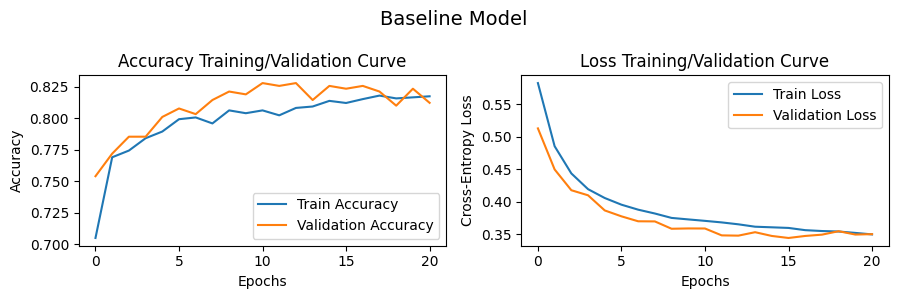

Final Results after 21 epochs:
Accuracy: Train=81.73% | Val=81.21%
Loss: Train=0.3496 | Val=0.3500


In [4]:
### Plot training and validation curves ###

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Accuracies plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy Training/Validation Curve')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Losses plot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss Training/Validation Curve')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Cross-Entropy Loss')
axes[1].legend()

# Show plots
fig.suptitle('Baseline Model', fontsize=14)
plt.tight_layout()
plt.show()

print(f'Final Results after {len(history.history['accuracy'])} epochs:')
print(f'Accuracy: Train={history.history['accuracy'][-1] * 100:.2f}% | Val={history.history['val_accuracy'][-1] * 100:.2f}%')
print(f'Loss: Train={history.history['loss'][-1]:.4f} | Val={history.history['val_loss'][-1]:.4f}')

In [5]:
### Adding L2 regularization and dropout layers ###

MAX_EPOCHS = 100

input_size = 10
output_size = 2
hidden_layer_size = 64
batch_size = 128
activation='relu'

l2_strength = 0.001
dropout_rate = 0.2

model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(10,)),
        tf.keras.layers.Dense(hidden_layer_size, activation=activation),
        tf.keras.layers.Dense(hidden_layer_size, activation=activation),
        tf.keras.layers.Dense(output_size, activation='softmax')
    ]
)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            hidden_layer_size, 
            activation=activation, 
            kernel_regularizer=tf.keras.regularizers.l2(l2_strength)
        ),
        tf.keras.layers.Dropout(dropout_rate), 

        tf.keras.layers.Dense(
            hidden_layer_size, 
            activation=activation, 
            kernel_regularizer=tf.keras.regularizers.l2(l2_strength)
        ),
        tf.keras.layers.Dropout(dropout_rate), 

        tf.keras.layers.Dense(
            output_size,
            activation='softmax',
        )
    ]
)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

history_m2 = model.fit(
    X_train,
    y_train,
    epochs=MAX_EPOCHS,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=[early_stopping]
)


Epoch 1/100
28/28 - 1s - 38ms/step - accuracy: 0.6616 - loss: 0.7033 - val_accuracy: 0.7450 - val_loss: 0.6187
Epoch 2/100
28/28 - 0s - 3ms/step - accuracy: 0.7265 - loss: 0.6080 - val_accuracy: 0.7539 - val_loss: 0.5483
Epoch 3/100
28/28 - 0s - 2ms/step - accuracy: 0.7438 - loss: 0.5632 - val_accuracy: 0.7696 - val_loss: 0.5071
Epoch 4/100
28/28 - 0s - 3ms/step - accuracy: 0.7538 - loss: 0.5288 - val_accuracy: 0.7875 - val_loss: 0.4848
Epoch 5/100
28/28 - 0s - 2ms/step - accuracy: 0.7550 - loss: 0.5088 - val_accuracy: 0.7897 - val_loss: 0.4681
Epoch 6/100
28/28 - 0s - 3ms/step - accuracy: 0.7687 - loss: 0.4935 - val_accuracy: 0.8031 - val_loss: 0.4556
Epoch 7/100
28/28 - 0s - 2ms/step - accuracy: 0.7684 - loss: 0.4959 - val_accuracy: 0.7964 - val_loss: 0.4484
Epoch 8/100
28/28 - 0s - 2ms/step - accuracy: 0.7698 - loss: 0.4881 - val_accuracy: 0.8009 - val_loss: 0.4424
Epoch 9/100
28/28 - 0s - 2ms/step - accuracy: 0.7773 - loss: 0.4792 - val_accuracy: 0.8143 - val_loss: 0.4335
Epoch 10/

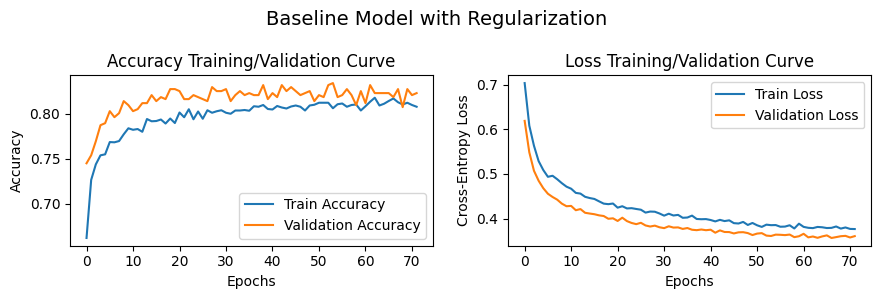

Final Results after 72 epochs:
Accuracy: Train=80.80% | Val=82.33%
Loss: Train=0.3766 | Val=0.3607


In [6]:
### Plot training and validation curves ###

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Accuracies plot
axes[0].plot(history_m2.history['accuracy'], label='Train Accuracy')
axes[0].plot(history_m2.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy Training/Validation Curve')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Losses plot
axes[1].plot(history_m2.history['loss'], label='Train Loss')
axes[1].plot(history_m2.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss Training/Validation Curve')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Cross-Entropy Loss')
axes[1].legend()

# Show plots
fig.suptitle('Baseline Model with Regularization', fontsize=14)
plt.tight_layout()
plt.show()

print(f'Final Results after {len(history_m2.history['accuracy'])} epochs:')
print(f'Accuracy: Train={history_m2.history['accuracy'][-1] * 100:.2f}% | Val={history_m2.history['val_accuracy'][-1] * 100:.2f}%')
print(f'Loss: Train={history_m2.history['loss'][-1]:.4f} | Val={history_m2.history['val_loss'][-1]:.4f}')